<a href="https://colab.research.google.com/github/anish-sk/CS6910_Assignment1/blob/master/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade wandb
!wandb login 6746f968d95eb71e281d6c7772a0469574430408

     |████████████████████████████████| 2.0MB 7.8MB/s 
     |████████████████████████████████| 133kB 52.1MB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
     |████████████████████████████████| 163kB 35.7MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=bd9fa8e6d7c0cdcc11704d25a2e8ffffa6b31347e29ce22b38314b9f6ab2d4a8
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=8035a9be66b110514aea90c0c6d6cf48700c6eba3fad758d9118bb18a82ab737
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
# Init wandb
import wandb

wandb.init(project="assignment1", entity="abisheks")

import numpy as np
from matplotlib import pyplot as plt
# Loading the fashion mnist dataset
from keras.datasets import fashion_mnist
# Setting seed value
np.random.seed(1)

# Load dataset (train data and test data)
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

# Summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

wandb: Currently logged in as: abisheks (use `wandb login --relogin` to force relogin)


4423680/4422102 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [4]:
# Number of classes in the Fashion-MNIST dataset
N_CLASSES = np.unique(trainy).shape[0]    # 10 as known from the keras documentation

# Captions/Labels for the output classes present in Fashion-MNIST dataset
IMG_LABELS = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


def getSampleImages(nClass, imgLabels, X, y, nSamples):
  '''
  The function takes few samples of each class from the dataset provided and passes it to the WANDB for it log the images

  Arguments :
    nClass -- Number of output classes in the dataset
    imgLabels -- List of labels for the output classes (numbered from 0 to nClass - 1)
    X -- The input data containing images in the form of matrices
    y -- The output data containing the class to which an input belongs
    nSamples -- Number of samples of each class to be taken. If that many samples not present in dataset, maximum number of samples present (from that class) will be taken

  Returns :
    -- None --
  '''

  # Initialise empty list to store the input data sampled from each class
  sampleImgsX = [[] for _ in range(nClass)]

  # Take 3 sample images from each class
  for i in range(y.shape[0]):
    if len(sampleImgsX[y[i]]) < nSamples :
      sampleImgsX[y[i]].append(X[i])


  # Getting a list of sample images of each class to be saved to wandb
  sampleImgsList = []
  for i in range(nClass):
    for j in range(3):
      sampleImgsList.append(wandb.Image(sampleImgsX[i][j], caption = imgLabels[i]))

  np.random.shuffle(sampleImgsList)
  wandb.log({"example" : sampleImgsList})


# Question 1 : Show 3 sample images from training set of downloaded Fashion-MNIST dataset in WANDB
getSampleImages(N_CLASSES, IMG_LABELS, trainX, trainy, 3)

In [5]:
def sigmoid(x):
  # Calculates the sigmoid function
  return np.exp(-np.logaddexp(0, -x))

def softmax(x):
  # Calculates the softmax function
  e_x = np.exp(x - np.max(x))
  return e_x / e_x.sum()

def linear(W, x, b):
  # Calculates the linear function
  return W @ x + b

def grad_sigmoid(x):
  # Calculates the gradient of sigmoid function
  return sigmoid(x) * (1 - sigmoid(x))

def grad_tanh(x):
  # Calculates the gradient of tanh function
  return 1 - np.tanh(x)**2

def Softmax_CrossEntropy_grad(y_pred, y):
  # Calculates the gradient of the output layer with softmax activation and cross entropy loss
  # layer -- The dictionary for the output layer contianing info about it
  # y -- True output
  return -(y - y_pred)

In [7]:
def random_initialisation(shape):
  # Initialising randomly structure with given dimensions (shape) as tuple
  return np.random.randn(*shape)*0.1

[[-0.00881041  0.08522393  0.0677234 ]
 [-0.01068784  0.07252741  0.09348892]]


In [ ]:
trainX_reshaped = trainX.reshape((trainX.shape[1]*trainX.shape[2], trainX.shape[0])) # Input Training data with ith column being ith training example's data

def initialize_network(n_L, preActFns_L, actFns_L, gradActFns_L, gradOutputFn, weight_initialisation):
  '''
  The function initializes the neural network and the appropriate parameters
  
  Arguments :
    n_L -- an array whose ith element represents the number of neurons in the ith layer (0 - Input Layer, last element - Output Layer)
    preActFns_L -- an array who ith element is the Pre Activation function of the (i+1)th layer of the neural network
    actFns_L -- an array who ith element is the Activation function of the (i+1)th layer of the neural network
    gradActFns_L -- an array who ith element is the gradient of the Activation function of the (i+1)th layer of the neural network
    gradOutputFn -- Function to calculate gradients wrt a_L (output layer) in back-propagation
    weight_initialisation -- Function to initialise weights of the layers
  
  Returns :
    network -- the initialized network as an array of dictionaries for the hidden and output layers of the neural network
  '''

  L = len(n_L)-1

  assert(L >= 1)
  assert(len(preActFns_L) == L)
  assert(len(actFns_L) == L)

  network = list()
  for i in range(1,L+1):
    # Dictionary for each layer representing it's constituents
    layer = {'weights':weight_initialisation((n_L[i],n_L[i-1]))   # Weight matrix for (i-1)th to ith layer transition
             'biases':np.zeros((n_L[i],1)),                       # Bias vector for (i-1)th to ith layer transition
             'pre_activation_fn':preActFns_L[i-1],                # Pre-activation function for neurons of the ith layer
             'activation_fn':actFns_L[i-1],                       # Activation function for neurons of the ith layer             
             'no_neurons':n_L[i],                                 # Number of neurons in ith layer
             'cache': []                                          # Array of cached pre-activation and activation output for each layer to be used in back-propagation (will be filled in forward-propagation)
            }
    network.append(layer)	
    if i < L:
      network[-1]['grad_activation_fn'] = gradActFns_L[i-1]       # Function calculating Gradient of the Activation function for the ith (hidden) layer
  
  network[-1]['grad_output_fn'] = gradOutputFn                    # Function calculating Gradient of the Output layer (Gradient of Loss function wrt a_L)

  return network


wandb.config.update({"n_hidden_layers": 3, "size_hidden_layer":32})    # Setting the hyperparameters in the wandb
L = wandb.config['n_hidden_layers']+1                                 # Number of hidden layerws + Output layer in the neural network
n_L = [wandb.config['size_hidden_layer']] * (L+1)                     # List of number of neurons in the neural network

n_L[0] = trainX.shape[1] * trainX.shape[2]
n_L[L] = N_CLASSES

pre_act_fns_L = [linear] * L                  # List of Pre-activation functions of the hidden layers and output layer
act_fns_L = [sigmoid] * (L-1) + [softmax]     # List of Activation functions of the hidden layers and output layer
grad_act_fns_L = [grad_sigmoid] * (L-1)       # List of Gradients of the Activation functions, of the hidden layers
grad_output_fn = Softmax_CrossEntropy_grad

network = initialize_network(n_L, pre_act_fns_L, act_fns_L, grad_act_fns_L, grad_output_fn, random_initialisation)
print(network)

[{'weights': array([[-0.00881041,  0.08522393,  0.0677234 , ..., -0.07874835,
         0.01889887, -0.11595327],
       [ 0.03937244,  0.01440401,  0.01090145, ...,  0.10540162,
         0.0028068 , -0.06242023],
       [-0.0672467 , -0.0132852 ,  0.00814284, ..., -0.16260238,
         0.11895941, -0.12354781],
       ...,
       [-0.09160877,  0.0055915 , -0.19319459, ..., -0.07105937,
         0.04063715, -0.0435853 ],
       [ 0.25698507, -0.1390457 , -0.12580865, ...,  0.08983811,
         0.09303237,  0.03137708],
       [-0.01846599, -0.14477292,  0.10282756, ..., -0.01756312,
        -0.09916802, -0.0430083 ]]), 'biases': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [ ]:
def pre_activation(H_prev, W, b, pre_activation_fn):
  # Calculates the pre-activation output and caches the required values. Returns the output and cache.
  A = pre_activation_fn(W, H_prev, b)
  
  assert(A.shape[0] == W.shape[0])
  pre_act_cache = A   # Caching the pre-activation ouptut to be used in backpropagation

  return A, pre_act_cache

def feedforward_neuron(H_prev, W, b, activation_fn, pre_activation_fn):
  # Calculates the activation output (using the pre-activation function above) and caches the required values. Returns the output and cache.

  H_prev = H_prev.reshape((H_prev.shape[0], 1))
  A, pre_activation_cache = pre_activation(H_prev, W, b, pre_activation_fn)
  H = activation_fn(A)
  
  assert (H.shape[0] == W.shape[0])
  H = H.reshape((H.shape[0],1))
  cache = (pre_activation_cache, H)   # Caching the pre-activation and activation output to use it in back-propagation

  return H, cache

In [ ]:
def forward_propagation(network, x):
    """
    Implement forward propagation for the given neural network
    
    Arguments :
      network -- Given neural network (as an array of dictionaries)
      x -- Input data from the training set
    
    Returns :
      Output from the neural network
    """

    H = x                         # Initialising H to input
    L = len(network)              # Number of (hidden + output) layers in the neural network
    cache_prev = (x,x) 
    for l in range(0, L):
        H_prev = H 
        H, cache = feedforward_neuron(H_prev, network[l]['weights'], network[l]['biases'], network[l]['activation_fn'], network[l]['pre_activation_fn'])
        network[l]['cache'] = cache_prev
        cache_prev = cache
    
    assert(H.shape[0] == (network[L-1]['no_neurons']))
            
    return H

# HL = forward_propagation(trainX_reshaped, network)          # HL -- output from the neural network
# print(HL)

In [ ]:
 def back_propagation(network, y, y_pred):
  """
    Implement backward propagation for the given neural network
    
    Arguments :
      network -- Given neural network (as an array of dictionaries)
      y -- True output corresponding to the training data input
    
    Returns :
      H -- Output from the neural network
  """

  L = len(network)

  # Gradients wrt output layer (a_L)
  grad_a_k_L = network[L-1]['grad_output_fn'](y_pred, y)

  # Initialising gradients to be calculated in the loop below
  grad_w_L = [np.zeros(2)] * L
  grad_b_L = [np.zeros(2)] * L
  grad_h_prev_L, grad_a_prev_L = 0, 0


  for k in range(L-1,-1,-1):
    # Gradients wrt Weights (W_k)
    grad_w_L[k] = grad_a_k_L @ network[k]['cache'][1].T

    # Gradients wrt Biases (b_k)
    grad_b_L[k] = grad_a_k_L

    # Gradients wrt hidden layer
    # Gradients wrt h_(k-1)
    grad_h_prev_L = network[k]['weights'].T @ grad_a_k_L

    # Gradients wrt a_(k-1)
    if(k > 0):
      grad_act_fn_prev = network[k-1]['grad_activation_fn'](network[k]['cache'][0])
      grad_a_prev_L = grad_h_prev_L * grad_act_fn_prev

    grad_a_k_L = grad_a_prev_L

  return grad_w_L, grad_b_L

In [ ]:
def CrossEntropy_loss(y_pred, y_true):
  return -(y_true * np.log(y_pred)).sum()

def SquaredError(y_pred, y_true):
  return ((y_true - y_pred) ** 2).sum()



  1%|          | 1/100 [00:24<40:57, 24.82s/it]

2.302125953933173



  2%|▏         | 2/100 [00:49<40:17, 24.67s/it]

2.3021105687838714



  3%|▎         | 3/100 [01:13<39:42, 24.56s/it]

2.302096186651937



  4%|▍         | 4/100 [01:38<39:32, 24.72s/it]

2.302082742947922



  5%|▌         | 5/100 [02:03<39:01, 24.65s/it]

2.302070177726248



  6%|▌         | 6/100 [02:28<38:46, 24.75s/it]

2.302058435273



  7%|▋         | 7/100 [02:52<38:20, 24.74s/it]

2.302047463566849



  8%|▊         | 8/100 [03:17<37:55, 24.73s/it]

2.302037213756326



  9%|▉         | 9/100 [03:41<37:15, 24.57s/it]

2.30202763973213



 10%|█         | 10/100 [04:06<36:59, 24.66s/it]

2.302018697816888



 11%|█         | 11/100 [04:30<36:22, 24.52s/it]

2.30201034658405



 12%|█▏        | 12/100 [04:55<35:57, 24.51s/it]

2.3020025467916514



 13%|█▎        | 13/100 [05:19<35:19, 24.36s/it]

2.3019952613653265



 14%|█▍        | 14/100 [05:43<34:40, 24.20s/it]

2.3019884553405605



 15%|█▌        | 15/100 [06:07<34:16, 24.19s/it]

2.301982095725948



 16%|█▌        | 16/100 [06:31<34:07, 24.37s/it]

2.3019761513412456



 17%|█▋        | 17/100 [06:56<33:47, 24.43s/it]

2.3019705927393



 18%|█▊        | 18/100 [07:20<33:14, 24.32s/it]

2.301965392300672



 19%|█▉        | 19/100 [07:44<32:44, 24.25s/it]

2.301960524499708



 20%|██        | 20/100 [08:09<32:30, 24.38s/it]

2.3019559662119877



 21%|██        | 21/100 [08:33<32:02, 24.34s/it]

2.3019516968408897



 22%|██▏       | 22/100 [08:58<31:44, 24.42s/it]

2.301947698069396



 23%|██▎       | 23/100 [09:22<31:12, 24.32s/it]

2.3019439532369965



 24%|██▍       | 24/100 [09:46<30:40, 24.22s/it]

2.301940446586025



 25%|██▌       | 25/100 [10:10<30:11, 24.16s/it]

2.3019371627042147



 26%|██▌       | 26/100 [10:34<29:52, 24.23s/it]

2.3019340863343105



 27%|██▋       | 27/100 [10:59<29:31, 24.27s/it]

2.301931202485445



 28%|██▊       | 28/100 [11:22<28:46, 23.98s/it]

2.301928496668534



 29%|██▉       | 29/100 [11:46<28:28, 24.06s/it]

2.3019259551120372



 30%|███       | 30/100 [12:11<28:18, 24.27s/it]

2.301923564898602



 31%|███       | 31/100 [12:35<27:59, 24.34s/it]

2.3019213140215253



 32%|███▏      | 32/100 [12:59<27:21, 24.14s/it]

2.301919191378064



 33%|███▎      | 33/100 [13:23<26:57, 24.15s/it]

2.3019171867205395



 34%|███▍      | 34/100 [13:48<26:42, 24.28s/it]

2.3019152905819897



 35%|███▌      | 35/100 [14:12<26:23, 24.37s/it]

2.301913494191578



 36%|███▌      | 36/100 [14:37<25:58, 24.36s/it]

2.3019117893932917



 37%|███▋      | 37/100 [15:01<25:36, 24.39s/it]

2.3019101685763474



 38%|███▊      | 38/100 [15:26<25:12, 24.39s/it]

2.3019086246215528



 39%|███▉      | 39/100 [15:50<24:48, 24.40s/it]

2.3019071508639857



 40%|████      | 40/100 [16:15<24:29, 24.49s/it]

2.3019057410682215



 41%|████      | 41/100 [16:39<24:02, 24.45s/it]

2.301904389412554



 42%|████▏     | 42/100 [17:03<23:36, 24.42s/it]

2.3019030904787336



 43%|████▎     | 43/100 [17:28<23:12, 24.42s/it]

2.3019018392451507



 44%|████▍     | 44/100 [17:52<22:51, 24.49s/it]

2.3019006310814465



 45%|████▌     | 45/100 [18:17<22:32, 24.59s/it]

2.3018994617454824



 46%|████▌     | 46/100 [18:42<22:12, 24.68s/it]

2.3018983273816134



 47%|████▋     | 47/100 [19:06<21:39, 24.52s/it]

2.3018972245209754



 48%|████▊     | 48/100 [19:31<21:09, 24.42s/it]

2.3018961500833846



 49%|████▉     | 49/100 [19:55<20:48, 24.49s/it]

2.3018951013794973



 50%|█████     | 50/100 [20:19<20:10, 24.20s/it]

2.3018940761108326



 51%|█████     | 51/100 [20:44<20:00, 24.50s/it]

2.3018930723645243



 52%|█████▏    | 52/100 [21:08<19:37, 24.52s/it]

2.3018920885980543



 53%|█████▎    | 53/100 [21:34<19:26, 24.81s/it]

2.3018911236106963



 54%|█████▍    | 54/100 [21:58<18:54, 24.65s/it]

2.301890176500611



 55%|█████▌    | 55/100 [22:22<18:23, 24.51s/it]

2.3018892466093237



 56%|█████▌    | 56/100 [22:47<18:01, 24.58s/it]

2.3018883334615334



 57%|█████▋    | 57/100 [23:12<17:35, 24.54s/it]

2.3018874367080726



 58%|█████▊    | 58/100 [23:36<17:08, 24.49s/it]

2.301886556081743



 59%|█████▉    | 59/100 [24:00<16:37, 24.34s/it]

2.3018856913693826



 60%|██████    | 60/100 [24:24<16:07, 24.20s/it]

2.3018848424011416



 61%|██████    | 61/100 [24:49<15:52, 24.43s/it]

2.3018840090499815



 62%|██████▏   | 62/100 [25:13<15:27, 24.42s/it]

2.3018831912343267



 63%|██████▎   | 63/100 [25:37<15:01, 24.36s/it]

2.301882388916717



 64%|██████▍   | 64/100 [26:02<14:37, 24.36s/it]

2.301881602092773



 65%|██████▌   | 65/100 [26:26<14:12, 24.35s/it]

2.3018808307714154



 66%|██████▌   | 66/100 [26:50<13:47, 24.34s/it]

2.301880074948282



 67%|██████▋   | 67/100 [27:15<13:28, 24.50s/it]

2.3018793345783517



 68%|██████▊   | 68/100 [27:40<13:08, 24.63s/it]

2.301878609552772



 69%|██████▉   | 69/100 [28:05<12:40, 24.52s/it]

2.3018778996840856



 70%|███████   | 70/100 [28:29<12:10, 24.36s/it]

2.301877204701022



 71%|███████   | 71/100 [28:53<11:46, 24.36s/it]

2.3018765242521515



 72%|███████▏  | 72/100 [29:17<11:19, 24.28s/it]

2.301875857915928



 73%|███████▎  | 73/100 [29:41<10:57, 24.35s/it]

2.301875205213572



 74%|███████▍  | 74/100 [30:06<10:32, 24.31s/it]

2.3018745656226884



 75%|███████▌  | 75/100 [30:30<10:08, 24.33s/it]

2.3018739385891336



 76%|███████▌  | 76/100 [30:55<09:47, 24.48s/it]

2.301873323536154



 77%|███████▋  | 77/100 [31:19<09:22, 24.44s/it]

2.30187271987073



 78%|███████▊  | 78/100 [31:44<09:01, 24.60s/it]

2.301872126987838



 79%|███████▉  | 79/100 [32:09<08:38, 24.71s/it]

2.301871544272587



 80%|████████  | 80/100 [32:34<08:13, 24.68s/it]

2.3018709711015517



 81%|████████  | 81/100 [32:58<07:48, 24.67s/it]

2.301870406843326



 82%|████████▏ | 82/100 [33:22<07:18, 24.37s/it]

2.3018698508595703



 83%|████████▎ | 83/100 [33:47<06:58, 24.62s/it]

2.30186930250614



 84%|████████▍ | 84/100 [34:11<06:30, 24.40s/it]

2.301868761134737



 85%|████████▌ | 85/100 [34:36<06:07, 24.47s/it]

2.3018682260959245



 86%|████████▌ | 86/100 [35:00<05:41, 24.40s/it]

2.3018676967428306



 87%|████████▋ | 87/100 [35:24<05:15, 24.29s/it]

2.301867172436305



 88%|████████▊ | 88/100 [35:49<04:53, 24.44s/it]

2.301866652552108



 89%|████████▉ | 89/100 [36:13<04:29, 24.49s/it]

2.301866136488986



 90%|█████████ | 90/100 [36:38<04:05, 24.50s/it]

2.3018656236801847



 91%|█████████ | 91/100 [37:02<03:40, 24.49s/it]

2.301865113605518



 92%|█████████▏| 92/100 [37:27<03:14, 24.36s/it]

2.3018646058072645



 93%|█████████▎| 93/100 [37:51<02:50, 24.40s/it]

2.301864099906218



 94%|█████████▍| 94/100 [38:16<02:26, 24.45s/it]

2.3018635956190225



 95%|█████████▌| 95/100 [38:40<02:02, 24.49s/it]

2.3018630927742776



 96%|█████████▌| 96/100 [39:04<01:37, 24.40s/it]

2.301862591325037



 97%|█████████▋| 97/100 [39:28<01:12, 24.10s/it]

2.3018620913550984



 98%|█████████▊| 98/100 [39:52<00:48, 24.12s/it]

2.301861593076679



 99%|█████████▉| 99/100 [40:16<00:24, 24.03s/it]

2.3018610968178366



100%|██████████| 100/100 [40:40<00:00, 24.41s/it]

2.30186060299952


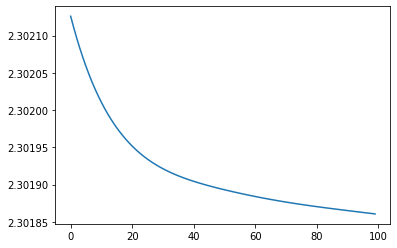

In [ ]:
from tqdm import tqdm
loss_values = []
def vanilla_gradient_descent(X, Y, network, eta = 5e-2, max_epochs = 100, loss_fn = CrossEntropy_loss):
  """
    Trains the neural network using Vanilla/Batch Gradient Descent
    
    Arguments :
      X -- Input data matrix where ith row is the input data corresponding to ith training example
      Y -- True output matrix where ith row is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      
    Returns :
      -- None --
  """
  
  L = len(network)
  M = X.shape[0]

  for i in tqdm(range(max_epochs)):  
    dw, db = [0] * L, [0] * L
    for k in range(L):
      dw[k] = np.zeros_like(network[k]['weights'])
      db[k] = np.zeros_like(network[k]['biases'])

    curr_loss = 0
    for x,y in zip(X, Y):
      x = x.reshape((x.shape[0],  1))
      y = y.reshape((y.shape[0], 1))
      y_pred = forward_propagation(network, x)
      curr_loss += (loss_fn(y_pred, y) / M)
      grad_w_L, grad_b_L = back_propagation(network, y, y_pred)
      for k in range(L):
        dw[k] += grad_w_L[k]
        db[k] += grad_b_L[k]
    loss_values.append(curr_loss)
    print(curr_loss)

    for k in range(L):
      # m1 = np.linalg.norm(dw[k])
      # if m1 > 0:
      #   dw[k] /= m1
      # m2 = np.linalg.norm(db[k])
      # if m2 > 0:
      #   db[k] /= m2
      dw[k] /= M
      db[k] /= M
      network[k]['weights'] -= eta * dw[k]
      network[k]['biases'] -= eta * db[k]

trainy_onehot = []
for y in trainy:
  curr_y = [0]*N_CLASSES
  curr_y[y] = 1
  trainy_onehot.append(curr_y)

trainy_onehot = np.array(trainy_onehot)

vanilla_gradient_descent(trainX_reshaped.T, trainy_onehot, network)
plt.plot(loss_values)
plt.show()

In [1]:
!pip freeze

absl-py==0.10.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
asgiref==3.3.1
astor==0.8.1
astropy==4.2
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
autograd==1.3
Babel==2.9.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.1.1
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.1
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.5
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.1
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.22
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
Django==3.1.7
dlib==19.18.0
dm-tree==0.1.5
doc